In [ ]:
# Our idea behind this labeling now is that we only look at the last purchase of each client per product category
# Because if a client comes back after a long gap, he is still a client 

# For the tresholds we still use the average difference in time between client purchases per product category

## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_theme(style="white", palette='Greens_r', font='serif')

In [4]:
client = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/rfm.feather")
trans = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/transactions.feather")

## Labelling

In [ ]:
neg_price = len(trans[trans["price"]<0])/len(trans)
print(f"Percentage of negative prices in data: {round(neg_price*100,2)}%")

Percentage of negative prices in data: 3.77%


In [ ]:
trans["price"].describe()

count    6.331932e+07
mean     2.361995e+01
std      1.391413e+02
min     -5.743100e+04
25%      7.118960e-01
50%      4.259600e+00
75%      1.629320e+01
max      4.354381e+05
Name: price, dtype: float64

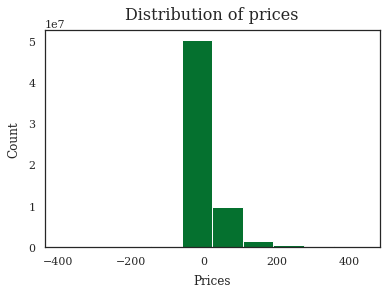

In [ ]:
# Remove outliers to show distribution
from scipy import stats
a_no_outliers = trans["price"][(np.abs(stats.zscore(trans["price"])) < 3)]
plt.hist(a_no_outliers, bins=10)
plt.xlabel("Prices", labelpad=8)
plt.ylabel("Count", labelpad=8)
plt.title("Distribution of prices", y=1.02, fontsize=16);
plt.show()

In [ ]:
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1.2,y_list[i-1],str(round(y_list[i-1]/len(trans[trans["price"]>0])*100,2))+ "%")

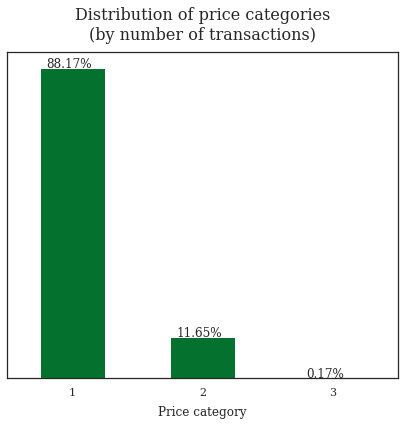

In [ ]:
# Make price categories
trans['price_cat'] = pd.cut(x=trans['price'], bins=[0,50,1000,500000],labels=[1,2,3]) # we don't want evenly distributed classes
fig , ax = plt.subplots()
values = list(trans['price_cat'].value_counts())
trans['price_cat'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Price category", labelpad=8)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
add_value_label([1,2,3],values)
plt.title("Distribution of price categories\n(by number of transactions)", y=1.02, fontsize=16);

In [ ]:
trans = trans.loc[:,["client_id","date_order","price_cat"]]
trans.dropna(axis=0, inplace = True)

In [ ]:
# splite dataframes for cat1, cat2 and cat3
price_category_1 = trans.query("price_cat == 1")
price_category_2 = trans.query("price_cat == 2")
price_category_3 = trans.query("price_cat == 3")

In [ ]:
# calculate time between last and first purchase per client

price_category_1['diff'] = price_category_1.groupby('client_id') \
                          ['date_order'] \
                           .transform(lambda x: (x.max()-x.min()).days)

price_category_2['diff'] = price_category_2.groupby('client_id') \
                        ['date_order'] \
                       .transform(lambda x: (x.max()-x.min()).days)

price_category_3['diff'] = price_category_3.groupby('client_id') \
                        ['date_order'] \
                        .transform(lambda x: (x.max()-x.min()).days)

In [ ]:
purchases_1 = price_category_1.groupby('client_id').size().reset_index()
purchases_2 = price_category_2.groupby('client_id').size().reset_index()
purchases_3 = price_category_3.groupby('client_id').size().reset_index()

In [ ]:
price_category_1 = pd.merge(price_category_1, purchases_1, how="left", left_on=["client_id"], right_on=["client_id"])
price_category_2 = pd.merge(price_category_2, purchases_2, how="left", left_on=["client_id"], right_on=["client_id"])
price_category_3 = pd.merge(price_category_3, purchases_3, how="left", left_on=["client_id"], right_on=["client_id"])

price_category_1.rename(columns = {0:'purchases'}, inplace = True)
price_category_2.rename(columns = {0:'purchases'}, inplace = True)
price_category_3.rename(columns = {0:'purchases'}, inplace = True)

price_category_1.head(20)

,client_id,date_order,price_cat,diff,purchases
0,835089,2017-09-25,1,725,1249
1,1977896,2017-09-25,1,406,438
2,598816,2017-09-25,1,714,2885
3,564878,2017-09-25,1,718,2572
4,482822,2017-09-25,1,711,134
5,1883627,2017-09-25,1,725,12969
6,224223,2017-09-25,1,725,860
7,434261,2017-09-25,1,725,1300
8,134706,2017-09-25,1,725,5566
9,234582,2017-09-25,1,717,2269


In [ ]:
price_category_1.dtypes

client_id             uint32
date_order    datetime64[ns]
price_cat           category
diff                   int64
purchases              int64
dtype: object

In [ ]:
price_category_1.iloc[1,3] / (price_category_1.iloc[1,4]-1)

0.9290617848970252

In [ ]:
# calculate average time between purchases of a client (=time difference/purchases)
price_category_1['Average_timespan'] = price_category_1.loc[:,"diff"] / (price_category_1.loc[:,"purchases"]-1)
price_category_2['Average_timespan'] = price_category_2.loc[:,"diff"] / (price_category_2.loc[:,"purchases"]-1)
price_category_3['Average_timespan'] = price_category_3.loc[:,"diff"] / (price_category_3.loc[:,"purchases"]-1)
price_category_1.head(20)

,client_id,date_order,price_cat,diff,purchases,Average_timespan
0,835089,2017-09-25,1,725,1249,0.580929
1,1977896,2017-09-25,1,406,438,0.929062
2,598816,2017-09-25,1,714,2885,0.247573
3,564878,2017-09-25,1,718,2572,0.279269
4,482822,2017-09-25,1,711,134,5.345865
5,1883627,2017-09-25,1,725,12969,0.055907
6,224223,2017-09-25,1,725,860,0.844005
7,434261,2017-09-25,1,725,1300,0.558122
8,134706,2017-09-25,1,725,5566,0.130279
9,234582,2017-09-25,1,717,2269,0.316138


In [ ]:
last_purchases1 = price_category_1.groupby('client_id').agg(avg_time=('date_order', "max"))
last_purchases2 = price_category_2.groupby('client_id').agg(avg_time=('date_order', "max"))
last_purchases3 = price_category_3.groupby('client_id').agg(avg_time=('date_order', "max"))

In [ ]:
last_date = trans["date_order"].max()
last_date

Timestamp('2019-09-22 00:00:00')

In [ ]:
last_purchases1["diff"] = last_date - last_purchases1["avg_time"]
last_purchases2["diff"] = last_date - last_purchases2["avg_time"]
last_purchases3["diff"] = last_date - last_purchases3["avg_time"]

In [ ]:
final = pd.merge(last_purchases1, last_purchases2, how="left", left_on=["client_id"], right_on=["client_id"])

In [ ]:
final = pd.merge(final, last_purchases3, how="left", left_on=["client_id"], right_on=["client_id"])

In [ ]:
final.drop(columns=["avg_time_x","avg_time_y","avg_time"], inplace = True)

In [ ]:
final.rename(columns={"diff_x":"diff_lb_p1","diff_y":"diff_lb_p2","diff":"diff_lb_p3"}, inplace=True)

In [ ]:
tresh1 = price_category_1.groupby('client_id').agg(avg_time=('Average_timespan', "first")).quantile(0.975)
tresh2 = price_category_2.groupby('client_id').agg(avg_time=('Average_timespan', "first")).quantile(0.975)
tresh3 = price_category_3.groupby('client_id').agg(avg_time=('Average_timespan', "first")).quantile(0.975)

In [ ]:
print(f"{tresh1}, {tresh2}, {tresh3}")

avg_time    98.544643
Name: 0.975, dtype: float64, avg_time    270.0
Name: 0.975, dtype: float64, avg_time    449.275
Name: 0.975, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1d9e7c850>]],
      dtype=object)

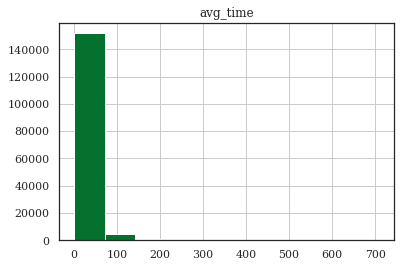

In [ ]:
price_category_1.groupby('client_id').agg(avg_time=('Average_timespan', "first")).hist()

In [ ]:
final = final.fillna(pd.Timedelta("-1 days"))

In [ ]:
final["diff_lb_p1"] = final["diff_lb_p1"].dt.days.astype("int16")
final["diff_lb_p2"] = final["diff_lb_p2"].dt.days.astype("int16")
final["diff_lb_p3"] = final["diff_lb_p3"].dt.days.astype("int16")

In [ ]:
final = final.replace(-1, np.NaN)

In [ ]:
conditions = [
    (final["diff_lb_p1"].isnull()),
    (final["diff_lb_p1"] <= tresh1[0]),
    (final["diff_lb_p1"] > tresh1[0])
    ]

values = [np.NaN, 0, 1]

final['churn_p1'] = np.select(conditions, values)

conditions = [
    (final["diff_lb_p2"].isnull()),
    (final["diff_lb_p2"] <= tresh2[0]),
    (final["diff_lb_p2"] > tresh2[0]),
    ]

values = [np.NaN, 0, 1]

final['churn_p2'] = np.select(conditions, values)

conditions = [
    (final["diff_lb_p3"].isnull()),
    (final["diff_lb_p3"] <= tresh3[0]),
    (final["diff_lb_p3"] > tresh3[0])
    ]

values = [np.NaN, 0, 1]

final['churn_p3'] = np.select(conditions, values)

In [ ]:
final1 = final.iloc[:,3:6]

In [ ]:
final1["nansum"] = final1.isnull().sum(axis=1)
final1["sum"] = final1.sum(axis=1)

In [ ]:
# A client churns only if he churns for all products (not taking into account NaN values)
final1["churn"] = np.where(final1["sum"]==3.0, 1, 0)

In [ ]:
client_churn = pd.DataFrame(final1["churn"])

In [ ]:
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1.2,y_list[i-1],str(round(y_list[i-1]/len(client_churn)*100,2))+ "%", fontsize=15)

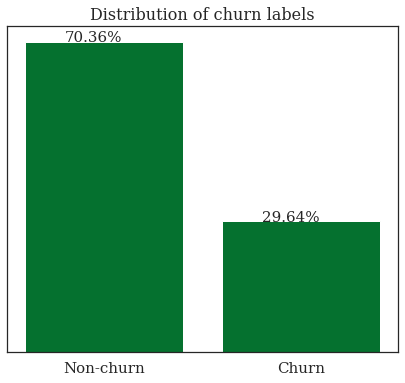

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
names = ["0","1"]
values = list(client_churn.value_counts())
ax.bar(names, values)
ax.set_xticklabels(['Non-churn', 'Churn'], fontsize=15)
ax.get_yaxis().set_visible(False)
ax.set_ylabel("Count")
add_value_label(names,values)
ax.set_title("Distribution of churn labels", fontsize=16);

In [ ]:
client_churn.reset_index().to_feather("/content/drive/MyDrive/Capstone Project/01 Data/client_churn.feather")


## Extra variable

In [ ]:
price_category_1.sort_values(by=['client_id'], inplace=True)
price_category_2.sort_values(by=['client_id'], inplace=True)
price_category_3.sort_values(by=['client_id'], inplace=True)

In [ ]:
price_category_1['new_client'] = price_category_1['client_id'].diff(1)
price_category_1['new_client'].fillna(0, inplace = True)

price_category_2['new_client'] = price_category_2['client_id'].diff(1)
price_category_2['new_client'].fillna(0, inplace = True)

price_category_3['new_client'] = price_category_3['client_id'].diff(1)
price_category_3['new_client'].fillna(0, inplace = True)

In [ ]:
price_category_1['diff'] = price_category_1['date_order'].diff(1)
price_category_1['diff'] = price_category_1['diff'].apply(lambda x: x.days).fillna(0)

price_category_2['diff'] = price_category_2['date_order'].diff(1)
price_category_2['diff'] = price_category_2['diff'].apply(lambda x: x.days).fillna(0)

price_category_3['diff'] = price_category_3['date_order'].diff(1)
price_category_3['diff'] = price_category_3['diff'].apply(lambda x: x.days).fillna(0)

In [ ]:
price_category_1.loc[price_category_1["new_client"] != 0,"diff"] = 0
price_category_2.loc[price_category_2["new_client"] != 0,"diff"] = 0
price_category_3.loc[price_category_3["new_client"] != 0,"diff"] = 0

price_category_1["churn"] = 0
price_category_2["churn"] = 0
price_category_3["churn"] = 0

In [ ]:
conditions = [
    (price_category_1["diff"] <= tresh1[0]),
    (price_category_1["diff"] > tresh1[0])
    ]

values = [0, 1]

price_category_1['churn'] = np.select(conditions, values)

conditions = [
    (price_category_2["diff"] <= tresh2[0]),
    (price_category_2["diff"] > tresh2[0])
    ]

values = [0, 1]

price_category_2['churn'] = np.select(conditions, values)

conditions = [
    (price_category_3["diff"] <= tresh3[0]),
    (price_category_3["diff"] > tresh3[0])
    ]

values = [0, 1]

price_category_3['churn'] = np.select(conditions, values)

In [ ]:
price_category_1

,client_id,date_order,price_cat,diff,purchases,Average_timespan,new_client,churn
33630702,6,2019-01-10,1,0.0,34,19.848485,0.0,0
47152902,6,2019-07-25,1,196.0,34,19.848485,0.0,1
4802250,6,2017-11-29,1,-603.0,34,19.848485,0.0,0
29984809,6,2018-11-23,1,359.0,34,19.848485,0.0,1
47164811,6,2019-07-25,1,244.0,34,19.848485,0.0,1
...,...,...,...,...,...,...,...,...
39846052,2274517,2019-04-09,1,434.0,70,10.086957,0.0,1
50083871,2274517,2019-08-29,1,142.0,70,10.086957,0.0,1
44856204,2274517,2019-06-25,1,-65.0,70,10.086957,0.0,0
22913485,2274517,2018-08-16,1,-313.0,70,10.086957,0.0,0


In [ ]:
new_category_1 = price_category_1.groupby(['client_id', 'price_cat']).agg({"churn": "sum"})
new_category_2 = price_category_2.groupby(['client_id', 'price_cat']).agg({"churn": "sum"})
new_category_3 = price_category_3.groupby(['client_id', 'price_cat']).agg({"churn": "sum"})
new_category_1

churn
client_id price_cat       
6         1             14
          2              0
          3              0
7         1              3
          2              0
...                    ...
2274508   2              0
          3              0
2274517   1             22
          2              0
          3              0

[499563 rows x 1 columns]

In [ ]:
new_category_2.head(80)

churn
client_id price_cat       
6         1              0
          2              0
          3              0
14        1              0
          2            400
...                    ...
453       1              0
          2              0
          3              0
481       1              0
          2              0

[80 rows x 1 columns]

In [ ]:
dfs = [new_category_1, new_category_2, new_category_3]
df_to = pd.concat(dfs, join='outer', axis=1).fillna(0)

In [ ]:
df_to["churn_sum"] = df_to.sum(axis=1) # this is the total sum of churns BETWEEN PURCHASES
df_to

churn  churn  churn  churn_sum
client_id price_cat                                
6         1           14.0    0.0    0.0       14.0
          2            0.0    0.0    0.0        0.0
          3            0.0    0.0    0.0        0.0
7         1            3.0    0.0    0.0        3.0
          2            0.0    0.0    0.0        0.0
...                    ...    ...    ...        ...
2274508   2            0.0    0.0    0.0        0.0
          3            0.0    0.0    0.0        0.0
2274517   1           22.0    0.0    0.0       22.0
          2            0.0    0.0    0.0        0.0
          3            0.0    0.0    0.0        0.0

[511758 rows x 4 columns]

In [ ]:
df_to.reset_index(inplace=True)
df_to.drop(columns=["price_cat","churn"],inplace=True)
limit = df_to.groupby('client_id').agg({"churn_sum": "sum"})

In [ ]:
limit = pd.merge(limit, client_churn, how="left", left_on=["client_id"], right_on=["client_id"])

In [ ]:
limitation = len(limit[(limit["churn_sum"] > 3) & (limit["churn"]==1)])/len(limit)*100

print(f"The labeling misses {limitation}% of churns before the last date")

The labeling misses 7.111955260103409% of churns before the last date


In [ ]:
limit.reset_index(inplace=True)
past_churn = limit[["client_id","churn_sum"]]
past_churn = past_churn.rename(columns={"churn_sum":"past_churn"})

In [ ]:
past_churn.to_feather("/content/drive/MyDrive/Capstone Project/01 Data/past_churn.feather")